# Week 4: Logistic Regression and Feature Scaling

This notebook implements a logistic regression model to classify the severity of cybersecurity incidents. Key preprocessing steps include:

- Encoding categorical target labels (Low, Medium, High, Critical) into numeric format.
- Scaling numeric input features to standardize magnitude.
- Applying regularization and cross-validation for improved generalization.

Evaluation is done through a confusion matrix, accuracy, and F1 score, illustrating how well the logistic regression model distinguishes between severity classes.

In [10]:
# Week 4: Logistic Regression & Feature Scaling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


df = pd.read_csv("cybersecurity_attacks.csv")
df = df.dropna(subset=['Severity Level'])

df['threat'] = df['Severity Level'].apply(lambda x: 1 if x in ['High', 'Medium'] else 0)
df['threat'].value_counts()


threat
1    26817
0    13183
Name: count, dtype: int64

In [11]:
# Features selected: Source/Destination Port + categorical encodings
features = ['Source Port', 'Destination Port', 'Protocol', 'Traffic Type']
df = df.dropna(subset=features)


df = pd.get_dummies(df, columns=['Protocol', 'Traffic Type'], drop_first=True)


X = df[['Source Port', 'Destination Port'] + 
       [col for col in df.columns if col.startswith('Protocol_') or col.startswith('Traffic Type_')]]
y = df['threat']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [12]:
logreg = LogisticRegression(max_iter=10000)
param_grid = {'C': np.logspace(-4, 4, 20)}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
logreg_cv.fit(X_train, y_train)

best_logreg = logreg_cv.best_estimator_
y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)[:, 1]

print("Best C:", logreg_cv.best_params_['C'])
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Best C: 29.763514416313132
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2673
           1       0.67      1.00      0.80      5327

    accuracy                           0.67      8000
   macro avg       0.33      0.50      0.40      8000
weighted avg       0.44      0.67      0.53      8000

ROC AUC: 0.5058863741883161


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


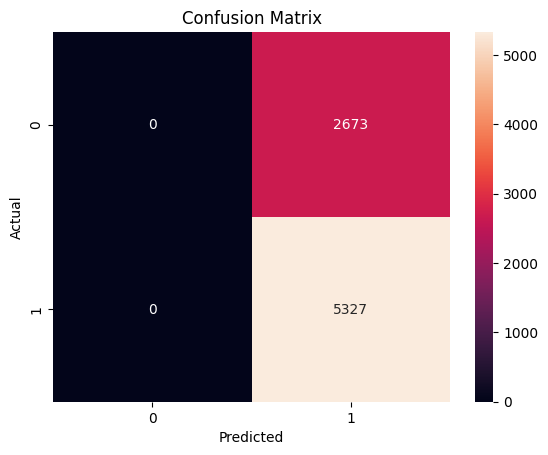

In [13]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


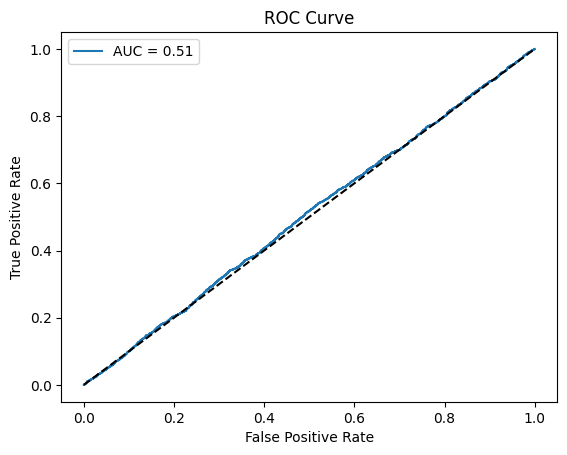

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
